# Analyze the effect of antipsychotics on gene expression

In [1]:
library(tidyverse)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Functions

In [2]:
save_img <- function(image, fn, w, h){
    for(ext in c(".svg", ".pdf", ".png")){
        ggsave(file=paste0(fn, ext), plot=image, width=w, height=h)
    }
}

get_pheno <- function(){
    phenotypes <- data.table::fread(paste0("/ceph/projects/v4_phase3_paper/inputs/",
                                           "phenotypes/_m/merged_phenotypes.csv")) %>% 
        mutate_if(is.character, as.factor)
    return(phenotypes)
}

memPHENO <- memoise::memoise(get_pheno)

In [3]:
pca_select <- function(norm_df){
    ### Dimensional reduction (PCA)
    log2cpm = norm_df %>% column_to_rownames("V1") %>% t
    pca_df = prcomp(log2cpm, center=TRUE)$x
    dt = pca_df %>% as.data.frame %>% rownames_to_column() %>% 
        pivot_longer(-rowname, names_to="PC", values_to="PC_values")
    return(dt)
}

memPCA <- memoise::memoise(pca_select)

## Normalized expression

In [4]:
memPHENO() %>% filter(Dx %in% c("CTL", "SZ"), Age > 13, 
                      Region == "Caudate") %>% 
    group_by(Dx, antipsychotics) %>% summarize(N=n())

`summarise()` has grouped output by 'Dx'. You can override using the `.groups` argument.



Dx,antipsychotics,N
<fct>,<lgl>,<int>
CTL,FALSE,246
SZ,FALSE,49
SZ,TRUE,104
SZ,NA,1


In [5]:
norm_df <- data.table::fread("../../main_plots/_m/caudate/normalized_expression.tsv")
norm_df[1:2, 1:5]

V1,R12864,R12865,R12866,R12867
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000227232.5,1.547013,1.538154,1.6061889,1.565640
ENSG00000278267.1,-1.405526,-1.866254,-0.7728476,-1.954495


In [6]:
dt = memPCA(norm_df) %>% mutate_if(is.character, as.factor)
dt %>% dim
dt %>% head(2)

[1] 154449      3

rowname,PC,PC_values
<fct>,<fct>,<dbl>
R12864,PC1,-35.34019
R12864,PC2,25.33034


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


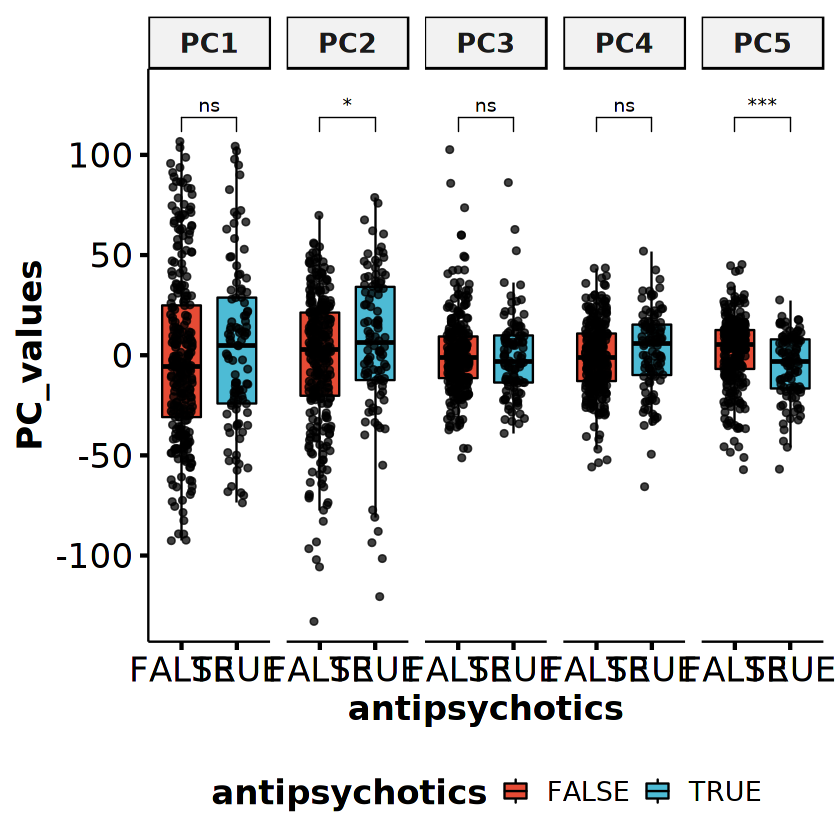

In [7]:
set.seed(20210723)
bxp = dt %>% filter(PC %in% c("PC1", "PC2", "PC3", "PC4", "PC5")) %>%
    inner_join(memPHENO(), by=c("rowname"="RNum")) %>% drop_na() %>%
    ggboxplot(x='antipsychotics', y="PC_values", fill='antipsychotics', add='jitter', 
              palette="npg", facet.by="PC", legend='bottom', add.params=list(alpha=0.75),
              panel.labs.font=list(face='bold'), ncol=5, ylim=c(-130, 130), 
              ggtheme=theme_pubr(base_size=20)) + 
        stat_compare_means(comparisons=list(c("TRUE", "FALSE")), aes(label=..p.signif..), 
                           method="wilcox.test") +
        font("title", color="black", face="bold") + font("xy.title", face="bold") + 
        font("legend.title", face="bold")
save_img(bxp, paste0("boxplot_antipsychotics_normalized"), w=12, h=4)
print(bxp)

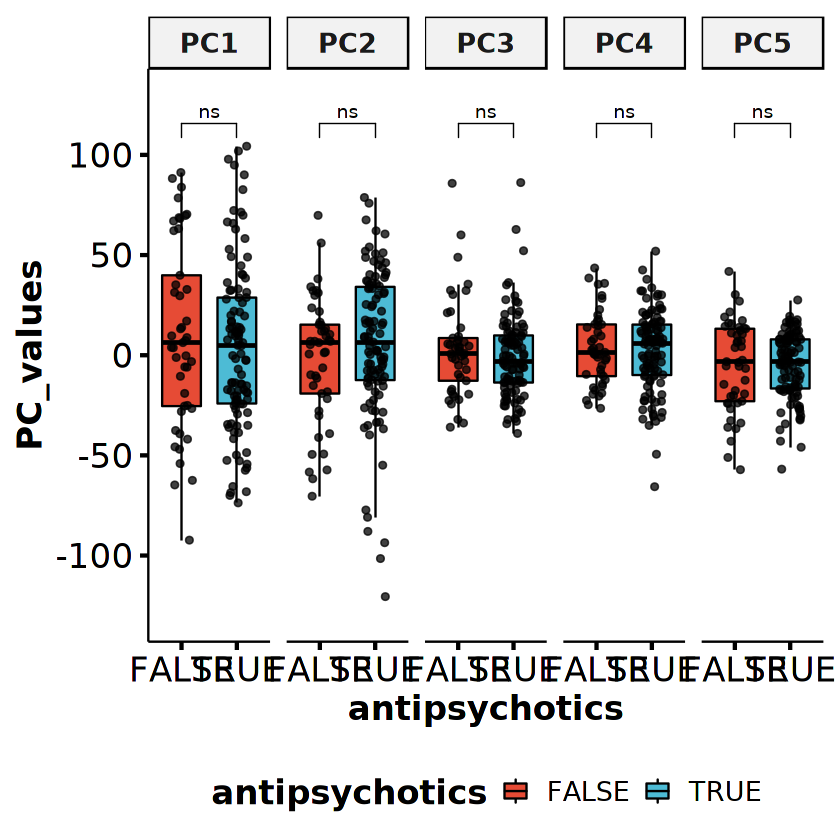

In [8]:
set.seed(20210723)
bxp = dt %>% filter(PC %in% c("PC1", "PC2", "PC3", "PC4", "PC5")) %>%
    inner_join(memPHENO(), by=c("rowname"="RNum")) %>% drop_na() %>%
    filter(Dx == "SZ") %>%
    ggboxplot(x='antipsychotics', y="PC_values", fill='antipsychotics', add='jitter', 
              palette="npg", facet.by="PC", legend='bottom', add.params=list(alpha=0.75),
              panel.labs.font=list(face='bold'), ncol=5, ylim=c(-130, 130), 
              ggtheme=theme_pubr(base_size=20)) + 
    stat_compare_means(comparisons=list(c("TRUE", "FALSE")), aes(label=..p.signif..), 
                       method="wilcox.test") +
    font("title", color="black", face="bold") + font("xy.title", face="bold") + 
    font("legend.title", face="bold")
save_img(bxp, paste0("boxplot_antipsychotics_normalized_szOnly"), w=12, h=4)
print(bxp)

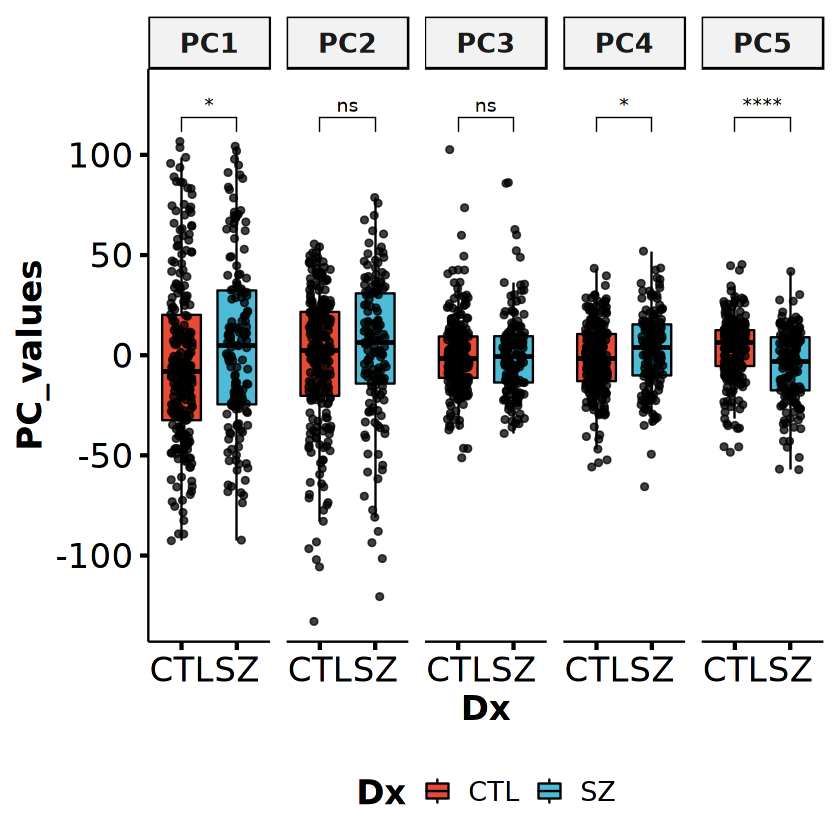

In [9]:
set.seed(20210723)
bxp = dt %>% filter(PC %in% c("PC1", "PC2", "PC3", "PC4", "PC5")) %>%
    inner_join(memPHENO(), by=c("rowname"="RNum")) %>% drop_na() %>%
    ggboxplot(x='Dx', y="PC_values", fill='Dx', add='jitter', 
              palette="npg", facet.by="PC", legend='bottom', add.params=list(alpha=0.75),
              panel.labs.font=list(face='bold'), ncol=5, ylim=c(-130, 130), 
              ggtheme=theme_pubr(base_size=20)) + 
    stat_compare_means(comparisons=list(c("CTL", "SZ")), aes(label=..p.signif..), 
                       method="wilcox.test") +
    font("title", color="black", face="bold") + font("xy.title", face="bold") + 
    font("legend.title", face="bold")
save_img(bxp, paste0("boxplot_dx_normalized"), w=12, h=4)
print(bxp)

### Statistical test for all significant PCs for antipsychotics

In [10]:
antipsychotics = dt %>% inner_join(memPHENO(), by=c("rowname"="RNum")) %>% drop_na()
pcs = c()
pvals = c()
for(pc in unique(antipsychotics$PC)){
    flush.console()
    dx = antipsychotics %>% filter(PC == pc)
    res = wilcox.test(filter(dx, antipsychotics=="TRUE")$PC_values,
                      filter(dx, antipsychotics=="FALSE")$PC_values)
    if(res$p.value < 0.05){
        pcs = c(pcs, pc)
        pvals = c(pvals, res$p.value)
    }
}

In [11]:
pcs

[1] "PC2"   "PC5"   "PC11"  "PC13"  "PC15"  "PC16"  "PC17"  "PC19"  "PC21" 
[10] "PC22"  "PC23"  "PC24"  "PC28"  "PC32"  "PC38"  "PC40"  "PC46"  "PC60" 
[19] "PC81"  "PC386"

## Residualized

In [12]:
res_df <- data.table::fread("../../main_plots/_m/caudate/residualized_expression.tsv")
res_df[1:2, 1:5]

V1,R12864,R12865,R12866,R12867
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000227232.5,-0.8066279,-0.90143820,-0.4152018,-0.8407762
ENSG00000278267.1,0.9416640,-0.06697099,1.3918914,0.5206415


In [13]:
dt = memPCA(res_df) %>% mutate_if(is.character, as.factor)
dt %>% dim
dt %>% head(2)

[1] 154449      3

rowname,PC,PC_values
<fct>,<fct>,<dbl>
R12864,PC1,-0.1760693
R12864,PC2,57.6305446


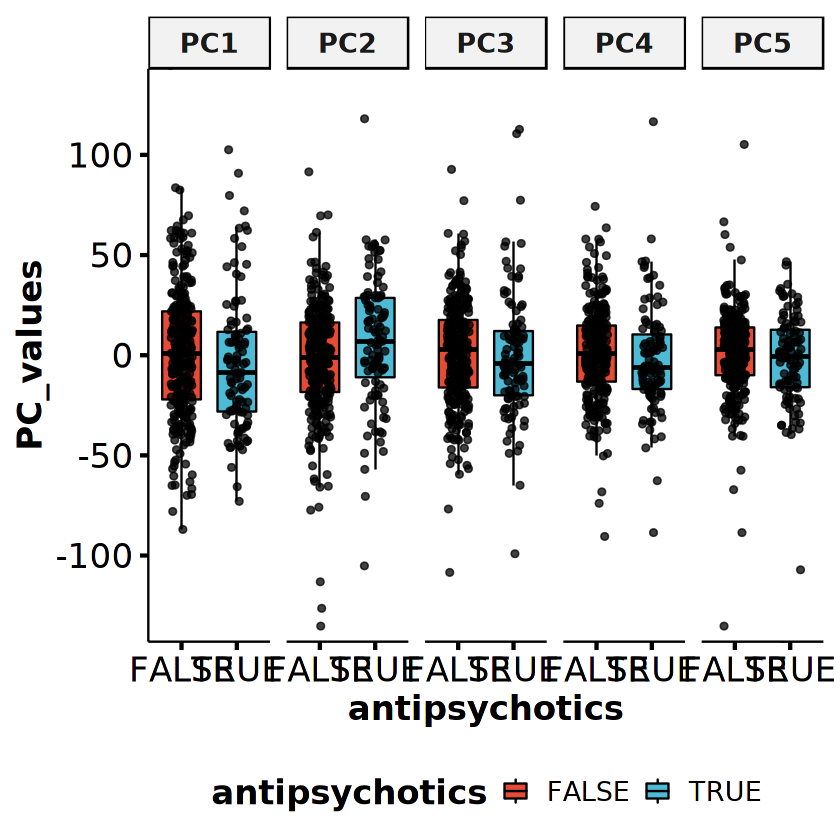

In [14]:
set.seed(20210723)
bxp = dt %>% filter(PC %in% c("PC1", "PC2", "PC3", "PC4", "PC5")) %>%
    inner_join(memPHENO(), by=c("rowname"="RNum")) %>% drop_na() %>%
    ggboxplot(x='antipsychotics', y="PC_values", fill='antipsychotics', add='jitter', 
              palette="npg", facet.by="PC", legend='bottom', add.params=list(alpha=0.75),
              panel.labs.font=list(face='bold'), ncol=5, ylim=c(-130, 130), 
              ggtheme=theme_pubr(base_size=20)) + 
    stat_compare_means(comparisons=list(c("TRUE", "FALSE")), aes(label=..p.signif..), 
                       method="wilcox.test") +
    font("title", color="black", face="bold") + font("xy.title", face="bold") + 
    font("legend.title", face="bold")
save_img(bxp, paste0("boxplot_antipsychotics_residualized"), w=12, h=4)
print(bxp)

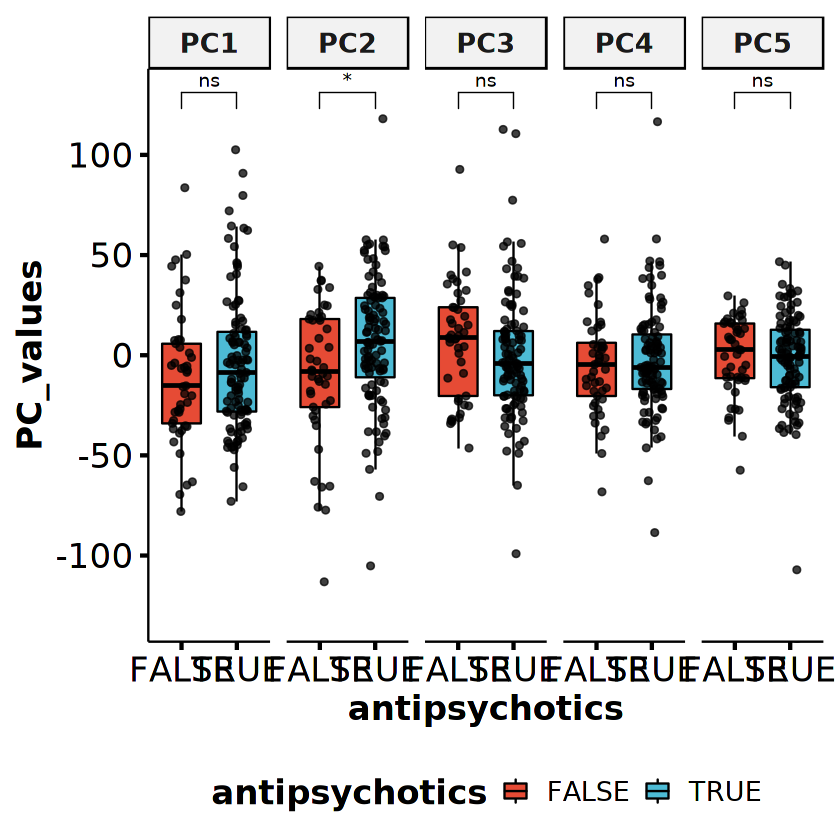

In [15]:
set.seed(20210723)
bxp = dt %>% filter(PC %in% c("PC1", "PC2", "PC3", "PC4", "PC5")) %>%
    inner_join(memPHENO(), by=c("rowname"="RNum")) %>% drop_na() %>%
    filter(Dx == "SZ") %>%
    ggboxplot(x='antipsychotics', y="PC_values", fill='antipsychotics', add='jitter', 
              palette="npg", facet.by="PC", legend='bottom', add.params=list(alpha=0.75),
              panel.labs.font=list(face='bold'), ncol=5, ylim=c(-130, 130), 
              ggtheme=theme_pubr(base_size=20)) + 
    stat_compare_means(comparisons=list(c("TRUE", "FALSE")), aes(label=..p.signif..), 
                       method="wilcox.test") +
    font("title", color="black", face="bold") + font("xy.title", face="bold") + 
    font("legend.title", face="bold")
save_img(bxp, paste0("boxplot_antipsychotics_residualized_szOnly"), w=12, h=4)
print(bxp)

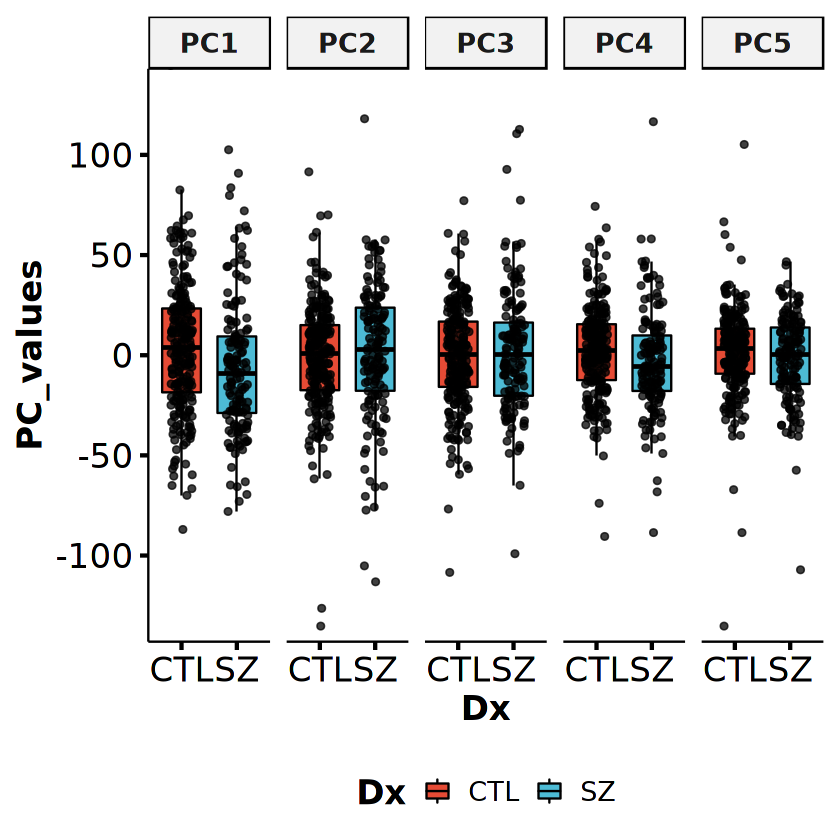

In [16]:
set.seed(20210723)
bxp = dt %>% filter(PC %in% c("PC1", "PC2", "PC3", "PC4", "PC5")) %>%
    inner_join(memPHENO(), by=c("rowname"="RNum")) %>% drop_na() %>%
    ggboxplot(x='Dx', y="PC_values", fill='Dx', add='jitter', 
              palette="npg", facet.by="PC", legend='bottom', add.params=list(alpha=0.75),
              panel.labs.font=list(face='bold'), ncol=5, ylim=c(-130, 130), 
              ggtheme=theme_pubr(base_size=20)) + 
    stat_compare_means(comparisons=list(c("CTL", "SZ")), aes(label=..p.signif..), 
                       method="wilcox.test") +
    font("title", color="black", face="bold") + font("xy.title", face="bold") + 
    font("legend.title", face="bold")
save_img(bxp, paste0("boxplot_dx_residualized"), w=12, h=4)
print(bxp)

### Statistical test for all significant PCs for antipsychotics

In [17]:
antipsychotics = dt %>% inner_join(memPHENO(), by=c("rowname"="RNum")) %>% drop_na()
pcs2 = c()
pvals2 = c()
for(pc in unique(antipsychotics$PC)){
    flush.console()
    dx = antipsychotics %>% filter(PC == pc)
    res = wilcox.test(filter(dx, antipsychotics=="TRUE")$PC_values,
                      filter(dx, antipsychotics=="FALSE")$PC_values)
    if(res$p.value < 0.05){
        pcs2 = c(pcs2, pc)
        pvals2 = c(pvals2, res$p.value)
    }
}

pcs2

[1] "PC1"   "PC2"   "PC6"   "PC7"   "PC9"   "PC13"  "PC17"  "PC18"  "PC19" 
[10] "PC24"  "PC30"  "PC33"  "PC297" "PC371" "PC375" "PC379" "PC382" "PC393"

## Reproducibility Information

In [18]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-07-23 14:23:44 EDT"

   user  system elapsed 
601.113 342.755  66.996 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-07-23                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 abind         1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat    0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports     1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom         0.7.8    2021-06-24 [1] CRAN (R 4.0.3)
 cachem        1.0.5    2021-05-15 [1] CRAN (R 